**2.HAFTA ÖDEV KONUSU : Bu hafta öğrendiğimiz Partial Dependence’ı ve Extrapolation Sorununu giderme konularını kendi seçtiğiniz bir veriye uygulamak.**

Geçen hafta üzerinde çalıştığım bike sharing demand veri seti üzerinde partial dependence ve extrapolasyon konularını inceliyor olacağım

In [1]:
# Gerekli kütüphanelerin import edilmesi

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import scipy
from pdpbox import pdp
from plotnine import *
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
import numpy as np
import math
import re
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from sklearn.ensemble import forest
import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH = "data/bike_sharing_demand/"  # dosya yolunu path ile tutuyorum

In [3]:
df_main= pd.read_csv(f'{PATH}train.csv', low_memory=False, 
                     parse_dates=["count"])  # dosyayı csv formatında okuyup üzerinde çalışacağımız dataframe haline getiriyorum.

In [4]:
df_main.head(10) # ilk 10 satırı gözlemleyelim

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,0,1,1
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,0,2
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,1,2,3
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,1,7,8
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,8,6,14


In [5]:
df_main.datetime = pd.to_datetime(df_main.datetime)

In [6]:
df_main.drop(['casual','registered'],axis=1,inplace=True)  # count feature'ı hedef değişken olduğu için bu 2 değişkenin toplamı doğrudan countu vereceği için silebiliriz.


In [7]:
# tüm kolonları görebilmek için display_all_dataframe fonksiyonunu oluşturalım

def display_all_dataframe(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [8]:
df_main["count"] =  df_main["count"].astype("float") # hedef değişkenin veri tipini objectten floata dönüştürelim

In [9]:
df_main["count"]  = np.log1p(df_main["count"])  # hedef değişkenin logaritmasını alalım (log1p olduğu için her değere 1 ekleyip log değeri hesaplanır)

In [10]:
weather=pd.get_dummies(df_main['weather'],prefix='weather')
df_=pd.concat([df_main,weather],axis=1)
#df_main.drop(['wheather','season'],axis=1,inplace=True)
# her bir sezon değeri için ayrı bir feature oluşturalım. Bunun nedeni özellikleri geliştirecek olmasıdır.
season=pd.get_dummies(df_main['season'],prefix='season')
df_main=pd.concat([df_main,season],axis=1)
df_main.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,season_1,season_2,season_3,season_4
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,2.833213,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,3.713572,1,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,3.496508,1,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,2.639057,1,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.693147,1,0,0,0


In [11]:
# bu fonksiyon sayesinde modele tarih ile ilgili yeni sütunlar eklenir ve model için anlamlı fraturelar üzerinde öalışılmaya yardımcı olunur

def add_info_datepart(df, dt_name, drop=True, time=True):
    "Creates new columns from our datetime column"
    
    
    dt_column = df[dt_name]
    column_dtype = dt_column.dtype
    

    targ_name = re.sub('[Dd]ate$', '', dt_name)
    
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    if time: 
        attr = attr + ['Hour'] # verilen datada sadece saat dataları var olduğundan dakika ve saniye bilgilerini bilmiyoruz
                                               
    for a in attr: 
        df[targ_name + a] = getattr(dt_column.dt, a.lower())
        
    # ne kadar zaman geçtiğini hesaplama için 1 sütun daha oluşturulalım
    df[targ_name + 'Elapsed'] = dt_column.astype(np.int64) // 10 ** 9
    
    if drop: 
        df.drop(dt_name, axis=1, inplace=True)

In [12]:
add_info_datepart(df_main, "datetime")  # fonksiyona gidildikten sonra datetine sütunu silinir bu sütından kazanılan bilgiler yeni kolonlara aktarılır.

In [16]:
# veri setimizin ilk n satırı train diğer satırlar validasyon datasına aktarılır

def split_train_val(df,n): 
    
    return df[:n].copy(), df[n:].copy()

In [17]:
# kullanacağımız metrik formülü

def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

In [18]:
# skor hesabı verilen veri seti için rmsle olduğundan log alınan verilere rmse uygulanır.
def print_score(m):
    
    print(f"RMSE of train set {rmse(m.predict(x), y)}")
    print(f"RMSE of validation set {rmse(m.predict(x_valid), y_valid)}")
    print(f"R^2 of train set {m.score(x, y)}")
    print(f"R^2 of validation set {m.score(x_valid, y_valid)}")

In [19]:
#Scikit'in rastgele ormanlarını öğrenip her ağaca rastgele bir örnek verecek şekilde değiştirir.

def set_rf_samples(n):

    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

In [20]:
# Set_rf_samples tarafından üretilen değişiklikleri geri alır


def reset_rf_samples():

    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [21]:
def numericalize(df, col, name, max_cat):
    if not is_numeric_dtype(col) and (max_cat is None or len(col.cat.categories)>max_cat):
        df[name] = pd.Categorical(col).codes+1

In [22]:

def fix_missing(df, col, name, nan_dict, is_train):
    
    if is_train:
        if is_numeric_dtype(col):
            if pd.isnull(col).sum():
                df[name+"_na"] = pd.isnull(col)
                nan_dict[name] = col.median()
                df[name] = col.fillna(nan_dict[name])
            
            
    else:
        if is_numeric_dtype(col):
            if name in nan_dict:
                df[name+"_na"] = pd.isnull(col)
                df[name] = col.fillna(nan_dict[name])
                
        
            else:
                df[name] = col.fillna(col.median())
            

In [23]:
def apply_proc_df(df, y_fld,nan_dict=None,is_train=True, max_cat=None):
    
    df = df.copy()
    y = df[y_fld].values
    
    df.drop(y_fld, axis = 1, inplace = True)
    
    if nan_dict is None:
        nan_dict = {}
    
    for n, c in df.items():
        fix_missing(df, c, n,nan_dict, is_train)
        numericalize(df, c, n, max_cat)
        
    df = pd.get_dummies(df, dummy_na=True)
        
    
    return df, y, nan_dict


In [24]:
# tüm verileri ele alarak model oluşturalım
n_valid = int(len(df_main)/10) 
n_trn = len(df_main)-n_valid

df_train, y_train, nan_dict = apply_proc_df(df_main, 'count', max_cat=7)

x, x_valid = split_train_val(df_train, n_trn)
y, y_valid = split_train_val(y_train, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(x, y)
print_score(m)

RMSE of train set 0.19549052964983785
RMSE of validation set 0.3536671143237344
R^2 of train set 0.9811182135993457
R^2 of validation set 0.931919950454948


In [28]:
x.shape,y.shape,x_valid.shape,y_valid.shape # tüm veri setini kullanarak 1/10'u val kalanını eğitim datası olarak ayırıp shape ile veri sayısı kontrolü yapıldı.

((9798, 26), (9798,), (1088, 26), (1088,))

In [29]:
#Subsampling yaparak model oluşturalım

# veri setimizden büyüklüğünü kendimiz bir örneklem kümesi alalım:
def get_sample(df,n):

    idxs = np.random.permutation(len(df))[:n]
    return idxs, df.iloc[idxs].copy()

In [30]:
idxs, xs = get_sample(x, 8000) # Veri setinden 800 tane örneklem alalım
ys = y[idxs]

In [31]:
xs.shape, ys.shape, x_valid.shape, y_valid.shape   # xs:x_sample and ys:y_sample

((8000, 26), (8000,), (1088, 26), (1088,))

In [33]:
# Oluşturduğumuz sample ile model kuruyoruz

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(xs, ys)
print_score(m)

RMSE of train set 0.22751670015264044
RMSE of validation set 0.36647773987152743
R^2 of train set 0.9744248497239755
R^2 of validation set 0.9268985980226356


In [34]:

def randomforest_feat_importance(m, df): # veri setindeki her kolonu önem derecesine göre sıralar
    return pd.DataFrame({'columns':df.columns, 'importance':m.feature_importances_}
                       ).sort_values('importance', ascending=False)


def plotting_importance(fi): # belirlenen önemli featureları görüntüler
    return fi.plot('columns', 'importance', 'barh', figsize=(12,7), legend=False)


def get_samples(df,n):
    
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [62]:
# En önemli featureları 1.ödevdeki feature importance ile belirledik

feature_importance = randomforest_feat_importance(m, df_train) #tüm kolonların importancelerını döndürür 

keep_columns = feature_importance[feature_importance["importance"]>0.005]["columns"]

df_keep = df_train[keep_columns].copy()

print("önemli görülenkolon sayısı\n",len(keep_columns))
print(keep_columns)

önemli görülenkolon sayısı:
 11
28         datetimeHour
29      datetimeElapsed
5                 atemp
4                  temp
20    datetimeDayofweek
2            workingday
6              humidity
21    datetimeDayofyear
18         datetimeWeek
3               weather
7             windspeed
Name: columns, dtype: object


In [35]:
# Önemlilik derecelerine göre featureları çizdirelim.

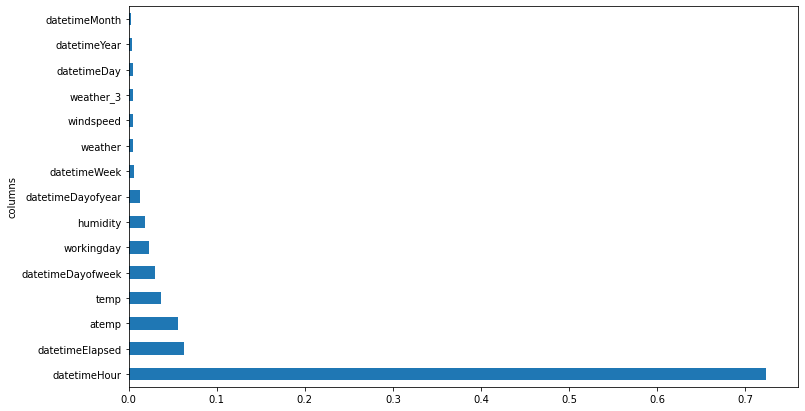

In [26]:
plotting_importance(randomforest_feat_importance(m, df_train)[:15]) 

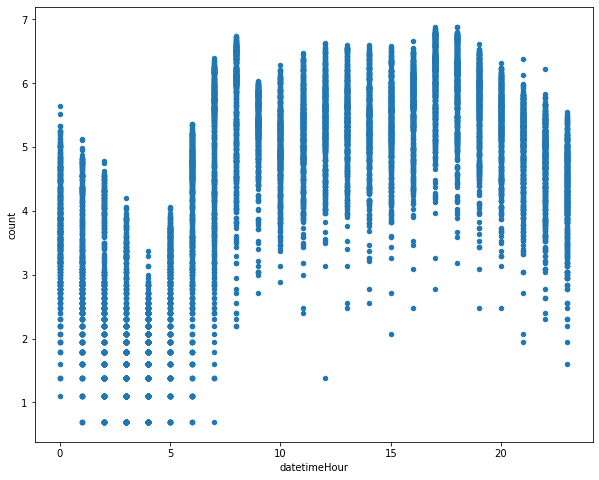

In [27]:
# mainplot yardımıyla datetimeHour değişkeninin hedef değişken ile ilgili etkisi belli bir aralıkta gösterilebilir.
# Bu örneğimde 0-24 saatleri arasında ortalama yapılan bisikleeet satışları gösterilmektedir(log olarak)

df_main.plot('datetimeHour', 'count', 'scatter', alpha=1, figsize=(10,8));

In [28]:
x_all = get_samples(df_main[df_main.datetimeHour>0], df_main.shape[0])
x_all.shape

(10431, 31)

In [29]:
display_all_dataframe(x_all.head())

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,weather_1,weather_2,weather_3,weather_4,season_1,season_2,season_3,season_4,datetimeYear,datetimeMonth,datetimeWeek,datetimeDay,datetimeDayofweek,datetimeDayofyear,datetimeIs_month_end,datetimeIs_month_start,datetimeIs_quarter_end,datetimeIs_quarter_start,datetimeIs_year_end,datetimeIs_year_start,datetimeHour,datetimeElapsed
1,1,0,0,1,9.02,13.635,80,0.0000,3.713572,1,0,0,0,1,0,0,0,2011,1,52,1,5,1,False,True,False,True,False,True,1,1293843600
2,1,0,0,1,9.02,13.635,80,0.0000,3.496508,1,0,0,0,1,0,0,0,2011,1,52,1,5,1,False,True,False,True,False,True,2,1293847200
3,1,0,0,1,9.84,14.395,75,0.0000,2.639057,1,0,0,0,1,0,0,0,2011,1,52,1,5,1,False,True,False,True,False,True,3,1293850800
4,1,0,0,1,9.84,14.395,75,0.0000,0.693147,1,0,0,0,1,0,0,0,2011,1,52,1,5,1,False,True,False,True,False,True,4,1293854400
5,1,0,0,2,9.84,12.880,75,6.0032,0.693147,0,1,0,0,1,0,0,0,2011,1,52,1,5,1,False,True,False,True,False,True,5,1293858000


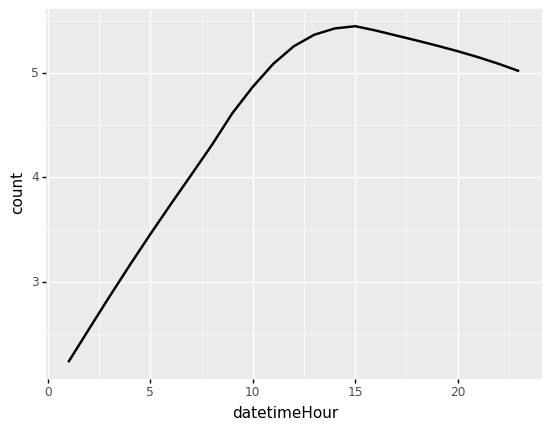

<ggplot: (-9223371862779900716)>

In [30]:
#ggplot yardımıyla saat bazında count değişimini göstrelim.

ggplot(x_all, aes('datetimeHour', 'count'))+stat_smooth(se=True, method='lowess' )

# KISMİ BAĞIMLILIKLARIN İNCELENMESİ


Rastgele orman ve güçlendirme gibi kara kutu makine öğrenimi algoritmalarını kullanırken, tahmin ediciler ve model sonucu arasındaki ilişkileri anlamak zordur. Örneğin, rastgele orman açısından, aldığımız tek şey özellik önemidir. Önem hesaplamasına dayanarak hangi özelliğin sonucu önemli ölçüde etkilediğini bilsek de, hangi yönü etkilediğini bilmiyor olmamız gerçekten kötü bir durumdur. Ve gerçek vakaların çoğunda, etki monoton değildir. Tahmin ediciler ve model tahmini arasındaki karmaşık ilişkileri anlamaya yardımcı olacak bazı güçlü araçlara ihtiyacımız var.

In [31]:
from pdpbox import pdp
from plotnine import *

# !pip install PDPbox==0.2.0 versiyonu kullanılmıştır. 0.1.0'da bazı hatalar ile karşılaşılmıştır.

In [37]:
x_sample = get_samples(x[x["datetimeHour"]>0], 1000)

In [38]:
x.columns.shape,x_sample.columns.shape,

((30,), (30,))

In [39]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x_sample, x_sample.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True,
                        cluster=clusters is not None,
                        n_cluster_centers=clusters)

In [40]:
feat = 'datetimeHour'

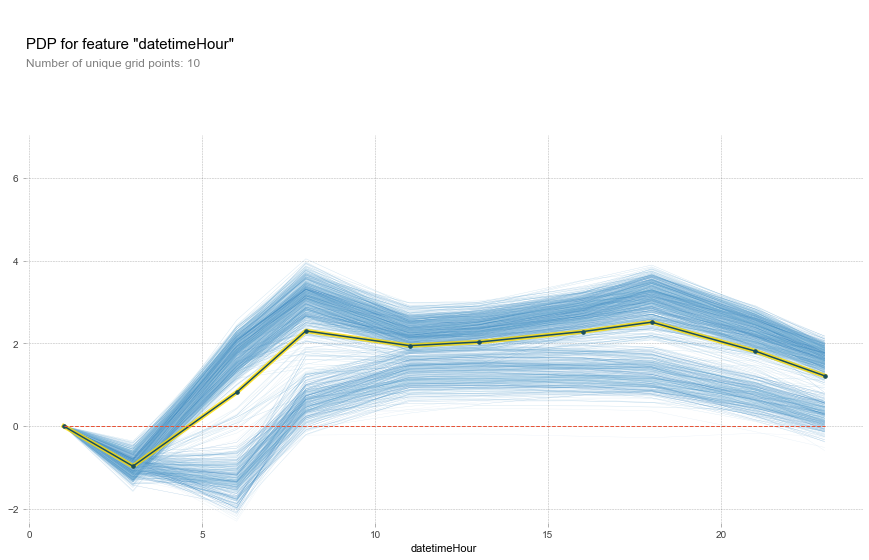

In [42]:
plot_pdp('datetimeHour') # Modelde en önemli feature olan datetimeHour'un tüm gözlem değerleri kullanılarak tahminleri ve ortalamayı çizdirelim.

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='datetimeHour'>})

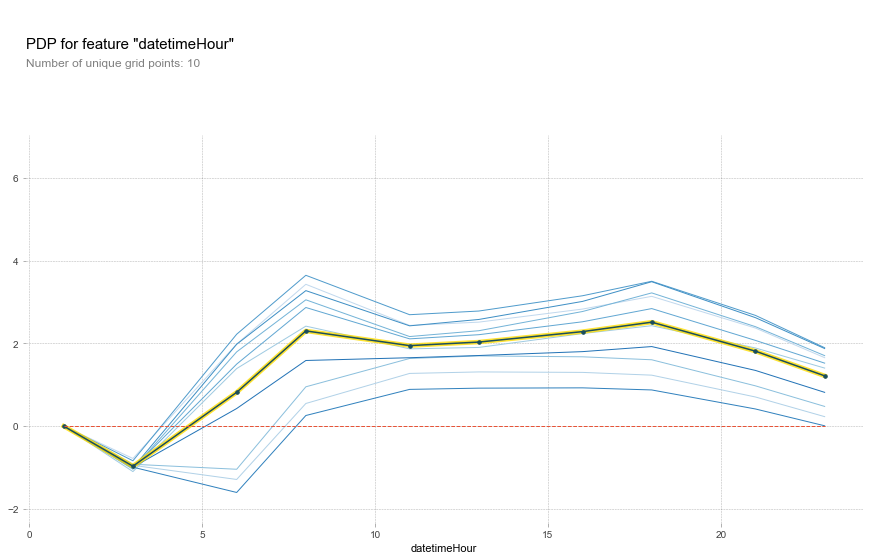

In [45]:
plot_pdp('datetimeHour', clusters = 10)  # 10 gözlem değeri ve bunun ortalamasını çizdirelim

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='atemp'>})

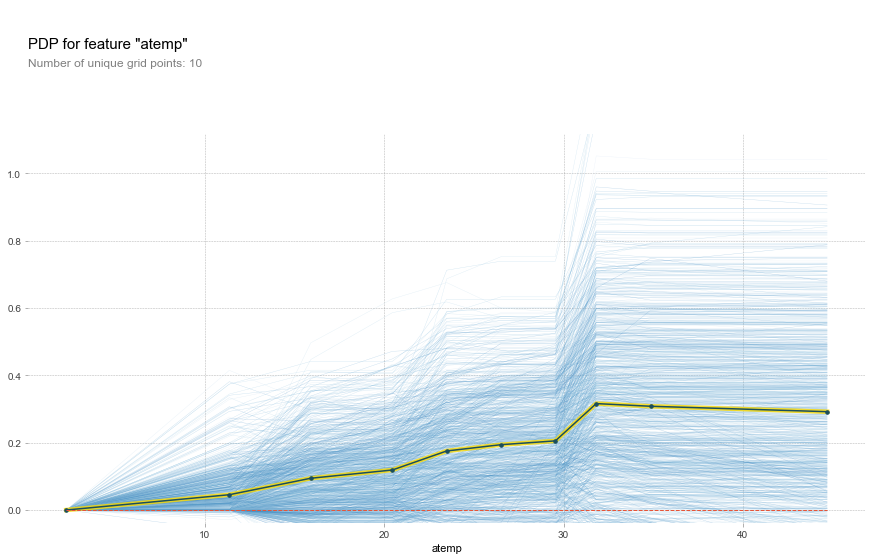

In [49]:
plot_pdp('atemp')  # Modelimizde diğer bir önemli feature olan atemp için tahminleri görselleştirelim.

# Çoklu Değişkenler Bağımlı Değişkeni Nasıl Etkiler?

In [58]:
# ?pdp_interact_plot
#pdp_interact kullanılarak belirlenen featurelar için etkileşim görselleştirilebilir.

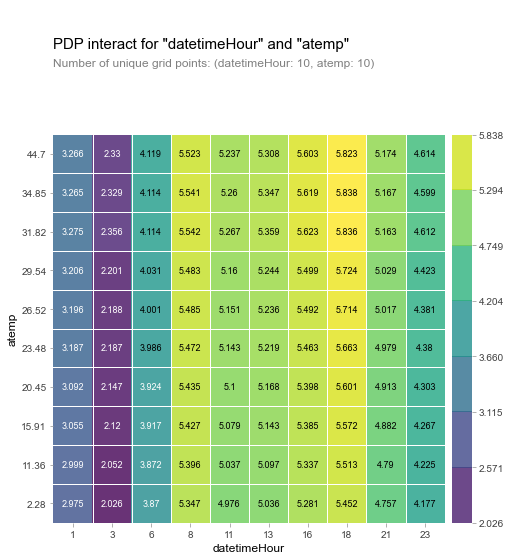

In [59]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['datetimeHour', 'atemp'] # Modeli en çok etkileyen featureların birbiri ile ilişkisini aynı grafikte gösterelim

interaction = pdp_interact(
  model=m,
  dataset=x_sample,
  model_features=x_sample.columns,
  features=features 
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features); 

#  Ekstrapolasyon Sorunu İle Başa Çıkma


Validation kümesinden gelip gelmediğini anlamak için is_valid olarak yeni bir sütun ekliyoruz

In [63]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = apply_proc_df(df_ext, 'is_valid')

In [64]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999081388939923

Bu modelin feature önemini bulursak, bu bize doğrulamadaki verileri eğitimden ayıran önemli parametreleri söyleyecektir.

In [66]:
fi = randomforest_feat_importance(m, x); fi[:10]

,columns,importance
1,datetimeElapsed,0.798020
7,datetimeDayofyear,0.147136
8,datetimeWeek,0.043429
3,temp,0.006794
2,atemp,0.001995
4,datetimeDayofweek,0.001076
6,humidity,0.000825
10,windspeed,0.000349
9,weather,0.000308
0,datetimeHour,0.000069


In [77]:
feats=['datetimeElapsed', 'datetimeDayofyear', 'datetimeWeek']

In [79]:
(x[feats]/1000).describe()

,datetimeElapsed,datetimeDayofyear,datetimeWeek
count,1.088600e+04,10886.000000,10886.000000
mean,1.324965e+06,0.177562,0.025918
std,1.818769e+04,0.105056,0.015017
min,1.293840e+06,0.001000,0.001000
25%,1.309591e+06,0.092000,0.014000
50%,1.325450e+06,0.182500,0.026000
75%,1.341147e+06,0.274000,0.040000
max,1.355958e+06,0.354000,0.052000


In [80]:
(x_valid[feats]/1000).describe()

,datetimeElapsed,datetimeDayofyear,datetimeWeek
count,1.088000e+03,1088.000000,1088.000000
mean,1.353280e+06,0.323475,0.046489
std,1.801776e+03,0.020857,0.003011
min,1.350054e+06,0.286000,0.041000
25%,1.352069e+06,0.309000,0.044000
50%,1.353051e+06,0.321000,0.046000
75%,1.354980e+06,0.343000,0.049000
max,1.355958e+06,0.354000,0.051000


In [81]:
x.drop(feats, axis=1, inplace=True)

In [82]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.92357155980158

In [83]:
fi = randomforest_feat_importance(m, x); fi[:10]

,columns,importance
5,humidity,0.195598
2,temp,0.179305
0,datetimeHour,0.148186
7,windspeed,0.142492
3,datetimeDayofweek,0.138540
1,atemp,0.131922
6,weather,0.039045
4,workingday,0.024912



Bike sharing demand yarışmanın test verilerini eğitim setinize koyup ve "is_test" adlı bir sütun oluşturalım, bu sütunu tahmin eden bir model oluşturalım. Modelimiz makul bir aralıkta tahmin yapabiliyorsa, bu, test setinin rastgele olmadığı anlamına gelir! Dolayısıyla, çapraz doğrulama ve yerleşik bölme yöntemleri test setini temsil etmeyecektir, bu nedenle doğrulama setinin nasıl oluşturulacağını bulmamız gerekir 

In [85]:
cols_feats=['humidity', 'temp', 'datetimeHour', 'windspeed', 'datetimeDayofweek', 'atemp']


cols_featsde belirtilen kolonları almak zararlı değilse, bu daha iyidir çünkü bu şekilde zaman içinde genelleyen daha iyi bir modele sahip olacağız.

In [90]:
y, y_valid = split_train_val(y_train, n_trn)

In [92]:
x, x_valid = split_train_val(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y)
print_score(m)

RMSE of train set 0.21285428040026658
RMSE of validation set 0.38622579943871743
R^2 of train set 0.9776150354998933
R^2 of validation set 0.9188080322653361


In [94]:
for f in cols_feats:
    df_subs = df_keep.drop(f, axis=1)
    x, x_valid = split_train_val(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(x, y)
    print(f)
    print_score(m)

humidity
RMSE of train set 0.21105053405764507
RMSE of validation set 0.4039245198643449
R^2 of train set 0.9779928124415685
R^2 of validation set 0.911196324706995
temp
RMSE of train set 0.2053318726053853
RMSE of validation set 0.3571057063568887
R^2 of train set 0.9791692757630716
R^2 of validation set 0.9305896737979006
datetimeHour
RMSE of train set 0.6403880087031704
RMSE of validation set 1.2554353041809647
R^2 of train set 0.7973820037670057
R^2 of validation set 0.1421345446071356
windspeed
RMSE of train set 0.20637472381559738
RMSE of validation set 0.35998165286986683
R^2 of train set 0.9789571459014267
R^2 of validation set 0.9294671814813364
datetimeDayofweek
RMSE of train set 0.21896575727716563
RMSE of validation set 0.3907222294270063
R^2 of train set 0.9763111465712153
R^2 of validation set 0.9169065586210592
atemp
RMSE of train set 0.2058380755383313
RMSE of validation set 0.35714419458254526
R^2 of train set 0.9790664415435766
R^2 of validation set 0.9305747111455882

In [105]:
reset_rf_samples()

In [106]:
#final modelimizin sonuçları :

df_subs = df_keep.drop(['temp', 'windspeed', 'atemp'], axis=1)
x, x_valid = split_train_val(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y)
print_score(m)

RMSE of train set 0.21454120737569599
RMSE of validation set 0.36081502028484125
R^2 of train set 0.977258815868689
R^2 of validation set 0.9291402326463521
